# Credit Card Fraud Detection_Supervised learning
Freference:    
    [recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)    
[Confusion Matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
    
    

In [32]:
# Import library and read csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_csv("data/creditcard2.csv",header=0)
occ = df['Class'].value_counts()
print(occ)
print(occ / len(df.index))

0    7000
1     300
Name: Class, dtype: int64
0    0.958904
1    0.041096
Name: Class, dtype: float64


#  Sampling

Synthetic Minority Oversampling Technique (SMOTE)
Resampling: removing samples from the majority class (under-sampling); adding more examples from the minority class (over-sampling).
    
SMOTE works randomly picing a point from the minority class and computing the k-nearest neighbors for this point. 
The synthetic points are added between the chosen point and its neighbors.

In [34]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,...,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,...,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,...,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,...,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,...,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


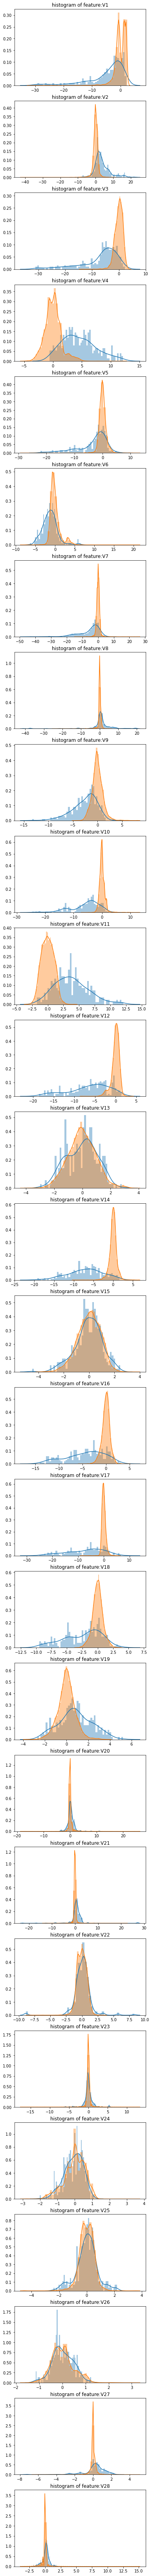

In [69]:
# distribution of anomalous features
from matplotlib import gridspec
features = df.iloc[:, 1:29].columns
plt.figure(figsize=(6,24*5))
gs = gridspec.GridSpec(28, 1)
for i, c in enumerate(df[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(df[c][df.Class == 1], bins=50)
 sns.distplot(df[c][df.Class == 0], bins=50)
 ax.set_xlabel('')
 ax.set_title('histogram of feature:'  + str(c))
plt.show()

In [35]:
# Preparing dataset
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    X = df.iloc[:, 1:29].values
    y = df.Class.values
    return X, y

# Create X and y from the prep_data function 
X, y = prep_data(df)


In [36]:
# Count the total number of non-fraudulent observations 
total_obs = len(y)
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

95.89%


In [37]:
# Set the input and output data
from sklearn.model_selection import train_test_split
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
np.unique(y_test)

array([0, 1], dtype=int64)

### Compare the resampling data with original set

In [38]:
# plot data
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 5], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 5], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

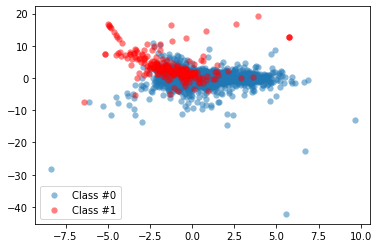

0    4892
1     218
dtype: int64


array([0, 1], dtype=int64)

In [39]:
plot_data(X_train, y_train)
print(pd.value_counts(pd.Series(y_train)))
np.unique(y_train)

# Autoencoders in Keras
[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

An autoencoder is a neural network model that seeks to learn a compressed representation of an input.

They are an unsupervised learning method, although technically, they are trained using supervised learning methods, referred to as self-supervised. They are typically trained as part of a broader model that attempts to recreate the input.

In [41]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = 28
encoding_dim = 28
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=200,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Using TensorFlow backend.


Train on 5110 samples, validate on 2190 samples
Epoch 1/200
5110/5110 [==============================] - 0s 58us/step - loss: 2.3937 - accuracy: 0.1566 - val_loss: 1.9804 - val_accuracy: 0.3388
Epoch 2/200
5110/5110 [==============================] - 0s 23us/step - loss: 2.2928 - accuracy: 0.3963 - val_loss: 1.8951 - val_accuracy: 0.4434
Epoch 3/200
5110/5110 [==============================] - 0s 19us/step - loss: 2.2144 - accuracy: 0.4515 - val_loss: 1.8422 - val_accuracy: 0.4909
Epoch 4/200
5110/5110 [==============================] - 0s 19us/step - loss: 2.1646 - accuracy: 0.4920 - val_loss: 1.7985 - val_accuracy: 0.5306
Epoch 5/200
5110/5110 [==============================] - 0s 19us/step - loss: 2.1219 - accuracy: 0.5360 - val_loss: 1.7639 - val_accuracy: 0.5804
Epoch 6/200
5110/5110 [==============================] - 0s 20us/step - loss: 2.0885 - accuracy: 0.5793 - val_loss: 1.7353 - val_accuracy: 0.6078
Epoch 7/200
5110/5110 [==============================] - 0s 19us/step - loss

5110/5110 [==============================] - 0s 19us/step - loss: 1.8179 - accuracy: 0.7748 - val_loss: 1.5090 - val_accuracy: 0.7813
Epoch 57/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.8182 - accuracy: 0.7714 - val_loss: 1.5106 - val_accuracy: 0.7817
Epoch 58/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.8165 - accuracy: 0.7703 - val_loss: 1.5079 - val_accuracy: 0.7950
Epoch 59/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.8150 - accuracy: 0.7744 - val_loss: 1.5077 - val_accuracy: 0.7963
Epoch 60/200
5110/5110 [==============================] - 0s 22us/step - loss: 1.8141 - accuracy: 0.7810 - val_loss: 1.5079 - val_accuracy: 0.7913
Epoch 61/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.8168 - accuracy: 0.7726 - val_loss: 1.5060 - val_accuracy: 0.7977
Epoch 62/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.8134 - accuracy: 0.7824 - val_loss: 1.5066 - val_a

Epoch 112/200
5110/5110 [==============================] - 0s 21us/step - loss: 1.7657 - accuracy: 0.7838 - val_loss: 1.4791 - val_accuracy: 0.8005
Epoch 113/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7649 - accuracy: 0.7818 - val_loss: 1.4794 - val_accuracy: 0.8005
Epoch 114/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7636 - accuracy: 0.7814 - val_loss: 1.4766 - val_accuracy: 0.7941
Epoch 115/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.7654 - accuracy: 0.7877 - val_loss: 1.4762 - val_accuracy: 0.7963
Epoch 116/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.7613 - accuracy: 0.7916 - val_loss: 1.4751 - val_accuracy: 0.8000
Epoch 117/200
5110/5110 [==============================] - 0s 21us/step - loss: 1.7606 - accuracy: 0.7834 - val_loss: 1.4757 - val_accuracy: 0.8009
Epoch 118/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.7616 - accuracy: 0.7861 - val_

5110/5110 [==============================] - 0s 20us/step - loss: 1.7519 - accuracy: 0.7945 - val_loss: 1.4689 - val_accuracy: 0.7959
Epoch 168/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7516 - accuracy: 0.7947 - val_loss: 1.4696 - val_accuracy: 0.7922
Epoch 169/200
5110/5110 [==============================] - 0s 19us/step - loss: 1.7498 - accuracy: 0.7926 - val_loss: 1.4737 - val_accuracy: 0.8082
Epoch 170/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7494 - accuracy: 0.7953 - val_loss: 1.4711 - val_accuracy: 0.8018
Epoch 171/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7513 - accuracy: 0.7912 - val_loss: 1.4706 - val_accuracy: 0.7986
Epoch 172/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7544 - accuracy: 0.7853 - val_loss: 1.4740 - val_accuracy: 0.8059
Epoch 173/200
5110/5110 [==============================] - 0s 20us/step - loss: 1.7516 - accuracy: 0.7943 - val_loss: 1.4699 -

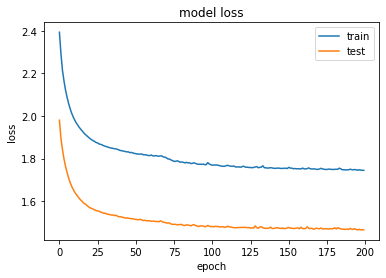

In [42]:
# plot the loss of model
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [43]:
# error distribution
autoencoder = load_model('model.h5')
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,2190.000000,2190.000000
mean,1.453301,0.037443
std,8.756409,0.189888
min,0.029122,0.000000
25%,0.213079,0.000000
50%,0.347275,0.000000
75%,0.595416,0.000000
max,264.054290,1.000000


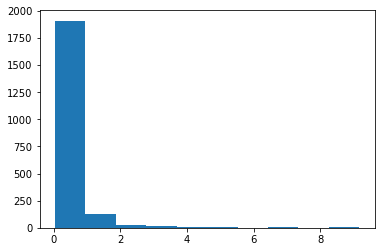

In [44]:
# Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

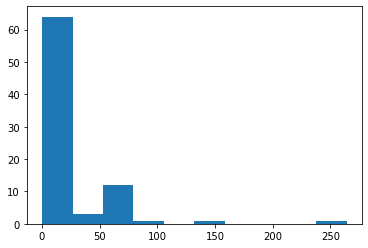

In [45]:
# Reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

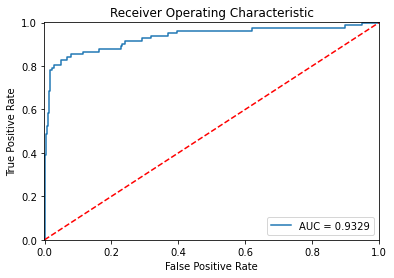

In [46]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


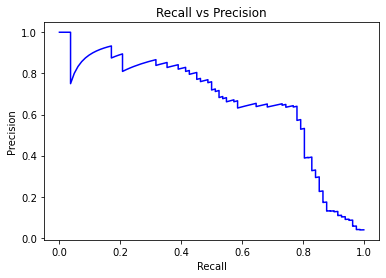

In [48]:
# precision vs recall

precision, recall,th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

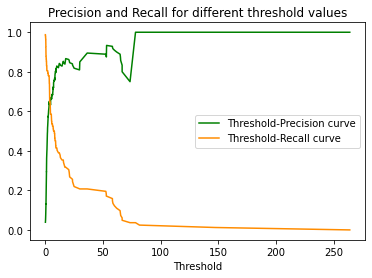

In [52]:
plt.plot(th, precision[1:], 'b', color = 'green',label='Threshold-Precision curve')
plt.plot(th, recall[1:], 'b', color = 'darkorange', label='Threshold-Recall curve')
plt.title('Precision and Recall for different threshold values')
plt.xlabel('Threshold')
plt.legend()
plt.show()

 ### Prediction
    In order to predict whether or not a new/unseen transaction is normal or fraudulent, calculate the reconstruction error from the transaction data
    If the error is larger than a predefined threshold,  mark it as a fraud 
    

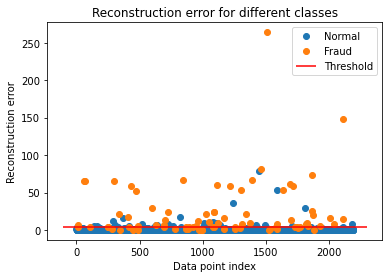

In [57]:
threshold = 4.5
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=6, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

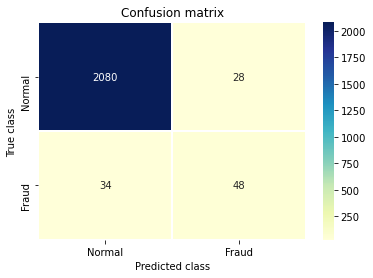

In [62]:
# plot the confusion matrix
import seaborn as sns
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure()
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Sampling for Classification

0.7.0


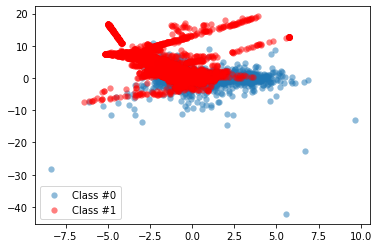

1    4892
0    4892
dtype: int64


In [63]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
method = SMOTE()
##### Create the resampled feature set
X_train, y_train = method.fit_sample(X_train, y_train)

plot_data(X_train, y_train)
print(pd.value_counts(pd.Series(y_train)))

In [64]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [65]:

### Define model evaluation function
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
   
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))
    print('\naccuracy:')
    print(model.score(X_test, y_test))
    print('ROC Score:')
    print(roc_auc_score(y_test, probs[:,1]))
    fallout, sensitivity, thresholds = roc_curve(y_test, probs[:,1])
    plt.plot(fallout, sensitivity, color = 'darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()
    
 

# Random Forest

ROC Score:
0.97886680242514

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2108
           1       0.92      0.83      0.87        82

    accuracy                           0.99      2190
   macro avg       0.96      0.91      0.93      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2102    6]
 [  14   68]]

accuracy:
0.9908675799086758
ROC Score:
0.97886680242514


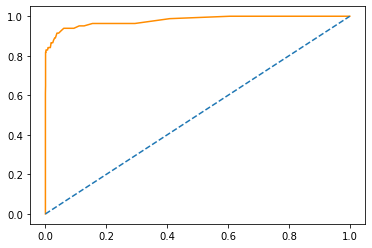

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=123, n_estimators=100)

# Fit training model to training set

model.fit(X_train, y_train)
get_model_results(X_train, y_train,X_test,y_test,model)

Precision: [0.03744292 0.91891892 1.        ]
Recall: [1.         0.82926829 0.        ]


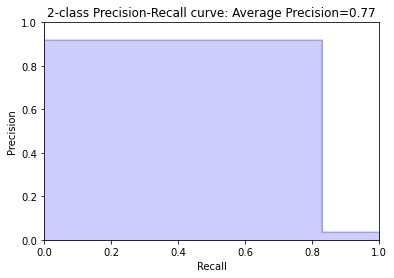

In [67]:
# Plotting the Precision vs. Recall Curve
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, predicted)
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

def plot_pr_curve(recall, precision, average_precision):
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: Average Precision={average_precision:0.2f}')
    return plt.show()
plot_pr_curve(recall, precision, average_precision)

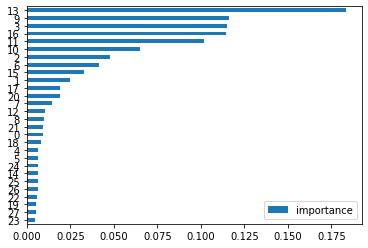

In [68]:
pd.DataFrame({'feature':df.columns.drop(['Unnamed: 0','Amount','Class']), 'importance':model.feature_importances_}).sort_values(['importance']).plot(kind='barh')

### Parameter optimization with GridSearchCV for RF

GridSearchCV evaluates all combinations of parameters defined in the parameter grid

In [16]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 10,20,30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=123)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 30}

ROC Score:
0.9797750728930439

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2108
           1       0.86      0.83      0.84        82

    accuracy                           0.99      2190
   macro avg       0.93      0.91      0.92      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097   11]
 [  14   68]]

accuracy:
0.9885844748858448
ROC Score:
0.9797750728930439


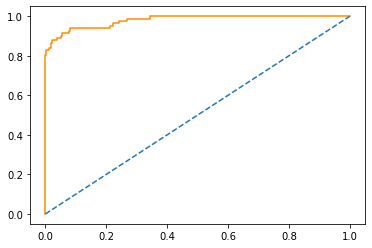

In [17]:
# Input the optimal parameters in the model
model = RandomForestClassifier(#class_weight={0:1, 1:12}, 
                               criterion='entropy',
                               max_depth=12,
                               max_features='auto', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=123)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

# Gradient boosted trees with XGBoost

D:\Program\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: -0.011878 using {'learning_rate': 0.4}
-0.684018 (0.000062) with: {'learning_rate': 0.0001}
-0.609144 (0.000518) with: {'learning_rate': 0.001}
-0.235054 (0.003974) with: {'learning_rate': 0.01}
-0.015308 (0.005835) with: {'learning_rate': 0.1}
-0.012383 (0.005723) with: {'learning_rate': 0.2}
-0.012104 (0.006403) with: {'learning_rate': 0.3}
-0.011878 (0.005848) with: {'learning_rate': 0.4}


Text(0, 0.5, 'Log Loss')

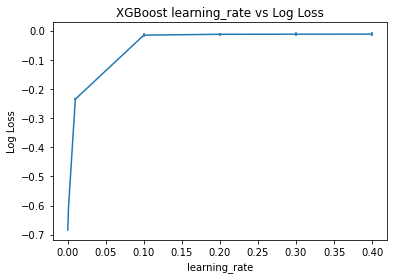

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
model = xgb.XGBClassifier(max_depth = 10)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0.4]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, np.ravel(y_train))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')

In [19]:
import time
start_time = time.time()
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = xgb.XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,0.5]
n_estimators = [100, 200, 300, 400, 500]
max_depth=[3,5,8,10,12]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, np.ravel(y_train))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("time lasting: \n", (time.time() - start_time))

Best: -0.008897 using {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
time lasting: 
 1959.8045063018799


In [20]:
# Train a model with the optmized learning rate
clf_gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 5,n_estimators=500).fit(X_train, np.ravel(y_train)) 
# Hyperparameters of gradient boosted trees

ROC Score:
0.9799486277595224

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2108
           1       0.88      0.83      0.86        82

    accuracy                           0.99      2190
   macro avg       0.94      0.91      0.92      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2099    9]
 [  14   68]]

accuracy:
0.9894977168949771
ROC Score:
0.9799486277595224


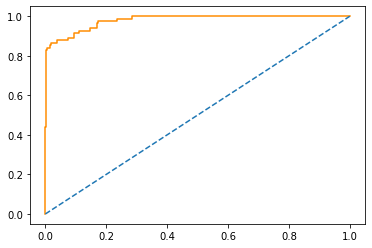

In [21]:
get_model_results(X_train, y_train, X_test, y_test, clf_gbt)

# Ensemble methods
Ensemble methods are techniques that create multiple machine learning models and then combine them to produce a final result

In [27]:
### Stacking Ensemble Methods_Voting Classifier

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=123,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=10, 
                              max_features='auto',
                              min_samples_leaf=10, 
                              n_estimators=20, 
                              n_jobs=-1,
                              random_state=123)

clf3 = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 5,n_estimators=500).fit(X_train, np.ravel(y_train))

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')



In [28]:
### Define model evaluation function
def get_model_results2(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
   
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    


    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))
    print('\naccuracy:')
    print(model.score(X_test, y_test))


In [29]:
# Get results 
get_model_results2(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2108
           1       0.57      0.85      0.68        82

    accuracy                           0.97      2190
   macro avg       0.78      0.91      0.83      2190
weighted avg       0.98      0.97      0.97      2190


Confusion Matrix:
[[2055   53]
 [  12   70]]

accuracy:
0.9703196347031964


In [30]:
### Adjusting weights within the Voting Classifier
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

In [31]:
# Get results 
get_model_results2(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2108
           1       0.61      0.84      0.70        82

    accuracy                           0.97      2190
   macro avg       0.80      0.91      0.85      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2063   45]
 [  13   69]]

accuracy:
0.9735159817351599


Not bad!